In [1]:
%load_ext jupyternotify
from pytket import Circuit, Qubit, Bit, OpType
from pytket.utils.operators import QubitPauliOperator
from sympy import symbols
from openfermion import QubitOperator
from random import sample
import numpy as np
from pytket.backends.projectq import ProjectQBackend
from pytket.backends.ibm import AerStateBackend, AerBackend, AerUnitaryBackend, IBMQBackend
from scipy.linalg import expm, sinm, cosm
from sympy.physics.quantum.dagger import Dagger
import functools
import operator
import itertools    
from openfermion import get_sparse_operator
from scipy.optimize import minimize, LinearConstraint
import matplotlib.pyplot as plt

backend = AerStateBackend()

def fidelity(rsv, gsv): 
    
    #rsv = real state vector 
    #gsv = generated statev vector 
    
    rsv_conj = np.conj(rsv)
    fid = sum(rsv_conj*gsv) * np.conj(sum(rsv_conj*gsv))
    
    return fid

#constants 
n = 1 #number of qubits 
lamb = np.float(2)
s = np.exp(-1 / (2 * lamb)) - 1
cst1 = (s / 2 + 1) ** 2
cst2 = (s / 2) * (s / 2 + 1)
cst3 = (s / 2) ** 2

<IPython.core.display.Javascript object>

In [2]:
def real(n, weights):
    
    real_circ = Circuit()
    qubits = real_circ.add_q_register('q', n)

    real_circ.Rx(weights[0], qubits[0])
        
    real_circ.Ry(weights[1], qubits[0])
        
    real_circ.Rz(weights[2], qubits[0])
        

    backend.compile_circuit(real_circ)
    state_handle = backend.process_circuit(real_circ)
    statevector = backend.get_state(state_handle)
    
    return real_circ, statevector


In [3]:
def generator(n, weights):
    
    generator_circ = Circuit()
    qubits = generator_circ.add_q_register('q', n)

    generator_circ.Rx(weights[0], qubits[0])

    generator_circ.Ry(weights[1], qubits[0])

    generator_circ.Rz(weights[2], qubits[0])
        
    backend.compile_circuit(generator_circ)
    state_handle = backend.process_circuit(generator_circ)
    statevector = backend.get_state(state_handle)
    
    return generator_circ, statevector


In [4]:
def discriminator(disc_weights, real_circ, real_sv, gen_circ, gen_sv):
    
    #creates the hermitian operators phi and psi 
    disc_weights_phi = disc_weights[:len(disc_weights)//2]
    disc_weights_psi = disc_weights[len(disc_weights)//2:]

    tuple_list_phi = [(weight, tup[0], tup[1]) for weight, tup in zip(disc_weights_phi, itertools.product(['X', 'Y', 'Z'], range(n)))]
    tuple_list_psi = [(weight, tup[0], tup[1]) for weight, tup in zip(disc_weights_psi, itertools.product(['X', 'Y', 'Z'], range(n)))]

    measurements_phi =  functools.reduce(operator.add, (weight * QubitOperator(f'{a}{n}') for weight, a, n in tuple_list_phi))
    measurements_psi =  functools.reduce(operator.add, (weight * QubitOperator(f'{a}{n}') for weight, a, n in tuple_list_psi))

    iden_phi =  functools.reduce(operator.add, ( (disc_weights_phi[len(disc_weights_phi)-1] ) * QubitOperator(" ") ))
    iden_psi =  functools.reduce(operator.add, ( (disc_weights_psi[len(disc_weights_psi)-1]) * QubitOperator(" ") ))

    phi = operator.add(iden_phi, measurements_phi)
    psi = operator.add(iden_psi, measurements_psi)

    #convert phi and psi operators to matrix 
    psi_matrix = get_sparse_operator(psi).todense()
    phi_matrix = get_sparse_operator(phi).todense()
    

    #calculate expectation values 
    psi_exp = backend.get_operator_expectation_value(real_circ, QubitPauliOperator.from_OpenFermion(psi))
    phi_exp = backend.get_operator_expectation_value(gen_circ, QubitPauliOperator.from_OpenFermion(phi)) 

    #calculate values for A and B which go into the calculation for the regterm
    A = expm(np.float(-1 / lamb) * phi_matrix)
    B = expm(np.float(1 / lamb) * psi_matrix)

    term1 = np.matmul(Dagger(gen_sv) , np.matmul(A, gen_sv))
    term2 = np.matmul(Dagger(real_sv), np.matmul(B,real_sv))
    term3 = np.matmul(Dagger(gen_sv), np.matmul(B,real_sv))
    term4 = np.matmul(Dagger(real_sv), np.matmul(A,gen_sv))
    term5 = np.matmul(Dagger(gen_sv), np.matmul(A,real_sv))
    term6 = np.matmul(Dagger(real_sv), np.matmul(B,gen_sv))
    term7 = np.matmul(Dagger(gen_sv), np.matmul(B,gen_sv))
    term8 = np.matmul(Dagger(real_sv), np.matmul(A,real_sv))

    regterm = (lamb / np.e * (cst1 * term1 * term2 - cst2 * term3 * term4 - cst2 * term5 * term6 + cst3 * term7 * term8)).item()

    return psi_exp , phi_exp , regterm
    


In [5]:
def disc_loss(disc_weights):
    
    psi_exp , phi_exp , regterm = discriminator(disc_weights, real_circ, real_sv, gen_circ, gen_sv)
    loss = np.real(psi_exp - phi_exp - regterm) 
    
    return -loss 

    
def gen_loss(gen_weights):

    gen_circ, gen_sv = generator(n, gen_weights)

    psi_exp , phi_exp , regterm = discriminator(disc_weights, real_circ, real_sv, gen_circ, gen_sv)
    loss = np.real(psi_exp - phi_exp - regterm)

    return loss 



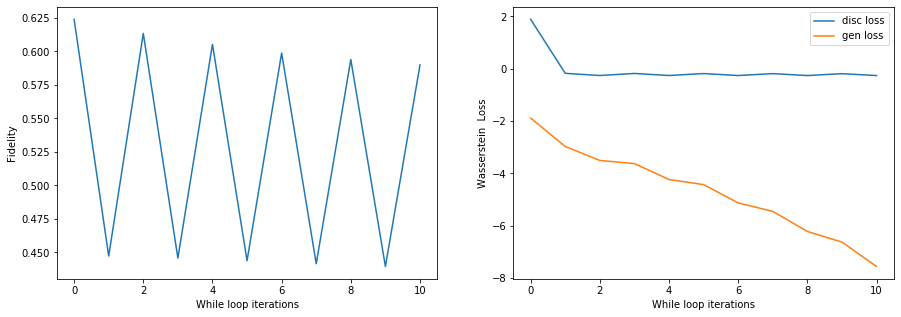

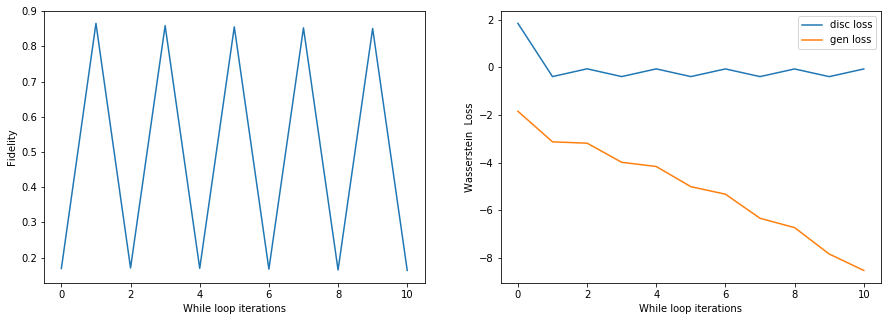

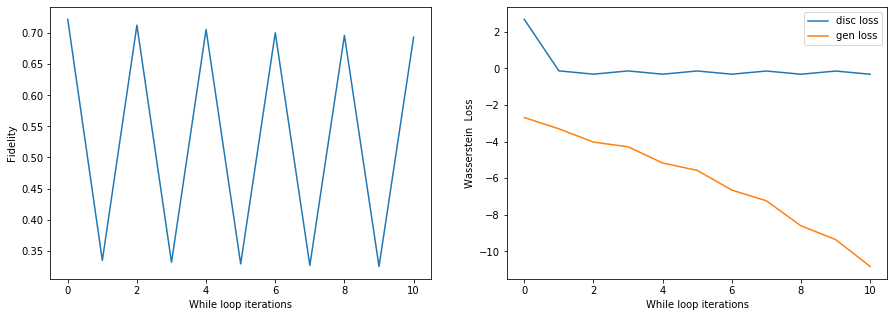

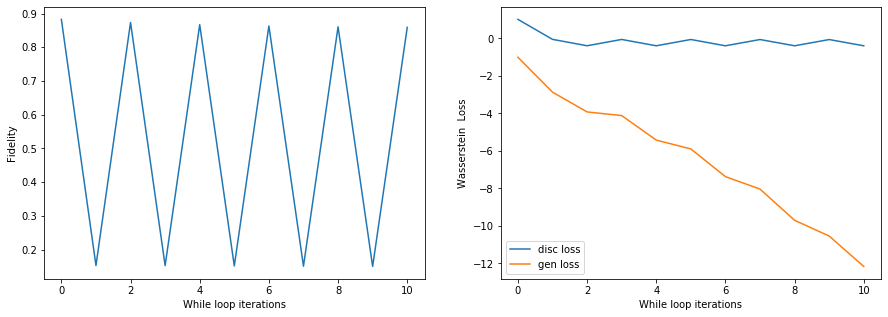

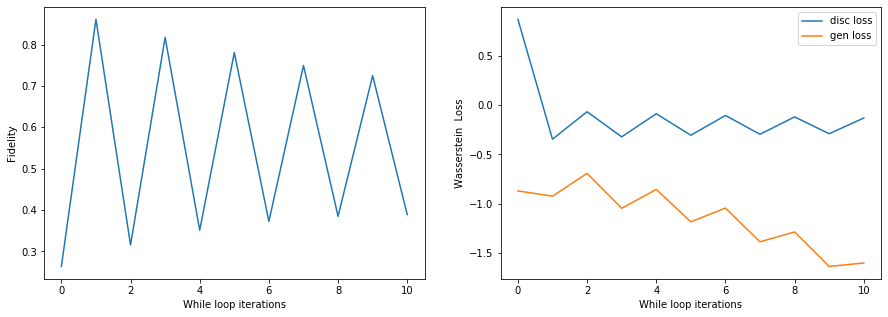

<IPython.core.display.Javascript object>

CPU times: user 35min 54s, sys: 29min 50s, total: 1h 5min 44s
Wall time: 9min 34s


In [7]:
%%time
%%notify


for r in range(5):
    
    #generate a random real state and a initial fake state and the disc params 
    real_weights = np.random.uniform(0,2,3) 
    init_gen_weights = np.random.uniform(0,2,3)
    init_disc_weights = np.random.uniform(0,2,8)
    

    gen_weights = init_gen_weights
    disc_weights = init_disc_weights


    real_circ, real_sv = real(n, real_weights)
    gen_circ, gen_sv = generator(n, init_gen_weights)
    init_fid = fidelity(real_sv, gen_sv)

    fid = init_fid


    dloss = []
    gloss = []
    f = []
    
    f.append(init_fid)
    dloss.append(disc_loss(disc_weights))
    gloss.append(gen_loss(gen_weights))

    niter = 0 
    while fid <0.99:

        #maximise loss for disc 
        disc_result = minimize(disc_loss, disc_weights, method='Powell',  options={ 'maxiter': 1000})
        disc_weights = disc_result.x
        dloss.append(float(disc_result.fun))

        #minimise loss for gen 
        gen_result = minimize(gen_loss, gen_weights, method='Powell', options={ 'maxiter': 300})
        gen_weights = gen_result.x
        gloss.append(float(gen_result.fun))
        
        #calculate the updated gen circ and statevector 
        gen_circ, gen_sv = generator(n, gen_weights)
        
        fid = fidelity(real_sv, gen_sv)

        f.append(fid)

        niter += 1

        if niter == 10:
            break 

            
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))


    y = np.real(f)
    x =list(range(0, len(y)))

    y1 = dloss
    x1 =list(range(0, len(y1)))
    
    y2 = gloss
    x2 =list(range(0, len(y2)))


    ax1.plot(x,y)
    ax2.plot(x1, y1, label = "disc loss")
    ax2.plot(x2, y2,  label = "gen loss")
    ax2.legend()


    ax1.set_xlabel('While loop iterations')
    ax1.set_ylabel('Fidelity')

    ax2.set_xlabel('While loop iterations')
    ax2.set_ylabel('Wasserstein  Loss')